# QJE Cleaning
This notebook walks through how the QJE articles were sorted into categories of articles and non-articles.

## Load Libraries

In [1]:
from tokenize import Ignore
import pandas as pd
from difflib import SequenceMatcher
import multiprocessing as mp
import time
from os import path
import os
from pathlib import Path
from PyPDF2 import PdfFileReader, PdfFileWriter
import re
import numpy as np
import matplotlib.pyplot as plt


pd.set_option('display.max_rows',None)
pd.set_option('display.max_colwidth', 120)   

## Load Files
Please change file paths to local and comment out file reads that are not present eg: datadump

In [2]:
base_path="/Users/sijiawu/Work/Thesis/Data"

In [11]:
masters = pd.read_excel(base_path+"/Masterlists/QJE_Masterlist.xlsx")
masters10 = pd.read_excel(base_path+ "/2010/QJE_master.xlsx")
pivots = pd.read_excel(base_path+"/Pivots/QJE_Pivots2020.xlsx")

## Create file names
For output

In [12]:
saveas=base_path+"/Processed/QJE_processed.xlsx"

## Some random checks on the masters list
My assumption is that all data without author names must be miscellaneous documents like reports by the committee, forewords, front matters etc.. The goal of this notebook is to check for certain that all the documents without author names are actually miscellaneous documents and then classify them as miscellaneous (MISC). Hence, first we group everything the data by title to see the repetitive general content that can likely be removed.

In [13]:
pd.set_option('display.max_rows',masters.shape[0])
temp=masters['title'].str.lower().value_counts()
pd.DataFrame(temp[temp>1])

,count
title,
front matter,416
back matter,413
volume information,178
recent publications,141
books received,100
recent publications upon economics,86
[notes and memoranda],39
the quarterly journal of economics,14
comment,4


Some repetitions are due to multiple comments. Now consider this list in absence of author names.

In [14]:
temp1=masters[masters['author'].isna()]['title'].str.lower().value_counts()
pd.DataFrame(temp1)

,count
title,
front matter,416
back matter,413
volume information,178
recent publications,141
books received,100
recent publications upon economics,86
[notes and memoranda],36
the quarterly journal of economics,14
[introduction],3


In [15]:
# block for testing regex patterns
#pd.DataFrame(masters[masters['content_type'].isna()]['title'].str.lower().value_counts())
#masters[masters['title'].str.lower().str.match(r'(^|: )report of the')]
#masters[masters['title'].str.lower().str.match(r'(^|.*: )report of the')]
#masters.loc[masters['title'].str.lower().str.match(r'^combined references(.*)')==True,'content_type']='MISC'


It seems anything with duplicates greater than 5 are miscellaneous according to the list above and the bulk of miscellaneous content can be removed.

In [16]:
temp2=masters[(masters['author'].isna()==True)]['title'].str.lower().value_counts()
pd.DataFrame(temp2)
removal=list(temp2[temp2>=3].index)
removal
masters.loc[masters.title.str.lower().isin(removal),'content_type']='MISC'

## Combine the scraped list with the citations files

I have found that masterlists contructed from citation files lack the reviewed source's name while it is present on the page of the article. Some files are just missing the title. So I'm combining the old masterlists with the new ones.

In [17]:
masters["URL"]="https:"+masters["URL"].str.split(':').str[-1]
masters.drop('type', inplace=True, axis=1)
masters10["stable_url"]="https:"+masters10["stable_url"].str.split(':').str[-1]
masters10.rename(columns = {'authors':'author','stable_url':'URL','title':'title_10'}, inplace = True)
masters['pages']=masters['pages'].str.strip()  
masters.loc[masters.title.str.lower() == "back matter", 'pages'] = pd.NA  
pivots['type']=pd.NA
masters['pages']=masters["pages"].str.split('pp. ').str[-1]
masters['pages']=masters['pages'].replace(r'--','-',regex=True).str.strip()

In [18]:
masters["author_split"]=masters['author'].str.split(' and ')
masters=masters.merge(masters10[['URL', 'title_10']], how='left', on='URL')

In [19]:
masters.loc[(pd.isna(masters["title"])==True)&(pd.isna(masters["reviewed-author"])==False), 'content_type']="Review"
masters.loc[(pd.isna(masters["reviewed-author"])==False), 'content_type']="Review"

In [20]:
masters.loc[(pd.isna(masters["title"])==True)&(pd.isna(masters["reviewed-author"])==False),"title"]=masters[(pd.isna(masters["title"])==True)&(pd.isna(masters["reviewed-author"])==False)]["title_10"]
masters.loc[(pd.isna(masters["title_10"])==False)&(pd.isna(masters["title"])==True)&(pd.isna(masters["reviewed-author"])==True)&(pd.isna(masters["author"])==True),"title"]=masters[(pd.isna(masters["title_10"])==False)&(pd.isna(masters["title"])==True)&(pd.isna(masters["reviewed-author"])==True)&(pd.isna(masters["author"])==True)]["title_10"]

In [21]:
for i in masters[(pd.isna(masters["title_10"])==False)&(pd.isna(masters["title"])==True)&(pd.isna(masters["reviewed-author"])==True)].index:
    temp=masters.iloc[i]
    indic=0
    if len(temp['author_split'])>1:
        for j in temp['author_split']:
            if j in temp["title_10"]:
                indic=1
                masters.loc[i, "title"]=temp["title_10"]
                masters.loc[i, "reviewed-author"]=j
                masters.loc[i, "content_type"]="Review"
                if "Review by:" in temp["title_10"]:
                    print("weird")
    if indic==0:
        masters.loc[i, 'title']=temp['title_10']

In [22]:
masters[masters.title.isna()]

,issue_url,ISSN,URL,journal,number,publisher,title,urldate,volume,year,abstract,author,pages,reviewed-author,uploaded,content_type,author_split,title_10


## Classifying miscellaneous documents

In [24]:
masters.loc[masters.title.str.lower() == "back matter", 'pages'] = pd.NA  
masters.loc[masters['title'].str.lower().str.match(r'\[introduction\]')==True,'content_type']='MISC'
masters.loc[masters['title'].str.lower().str.match(r'notes and memoranda')==True,'content_type']='MISC'
masters.loc[masters['title'].str.lower().str.match(r'the schumpeter prize$')==True,'content_type']='MISC'
masters.loc[masters['title'].str.lower().str.match(r'acknowledgement')==True,'content_type']='MISC'
masters.loc[masters['title'].str.lower().str.match(r'editorial')==True,'content_type']='MISC'
masters.loc[masters['title'].str.lower().str.match(r'index, volume')==True,'content_type']='MISC'
masters.loc[masters['title'].str.lower().str.match(r'harvard university courses in economics for 1928-29')==True,'content_type']='MISC'
masters.loc[masters['title'].str.lower().str.match(r'notice')==True,'content_type']='MISC'
masters.loc[masters['title'].str.lower().str.match(r'subscriptions')==True,'content_type']='MISC'
masters.loc[masters['title'].str.lower().str.match(r'volume matter')==True,'content_type']='MISC'


In [25]:
masters[masters['title'].str.lower().str.match(r'notice')==True]

,issue_url,ISSN,URL,journal,number,publisher,title,urldate,volume,year,abstract,author,pages,reviewed-author,uploaded,content_type,author_split,title_10
1935,https://www.jstor.org/stable/10.2307/i332451,"00335533, 15314650",https://www.jstor.org/stable/1885532,The Quarterly Journal of Economics,2,Oxford University Press,Notice to Our Readers,2023-09-12,99,1984,NaN,NaN,383-384,NaN,1,MISC,NaN,Notice to Our Readers



## Classifying other content

In [26]:
sum(masters.content_type.isna())
#masters.shape[0]

5350

In [27]:
# masters.loc[masters['authors'].str.lower().str.match(r'^review(ed|) by(.*)')==True,'content_type']='Review' #reviews
# masters.loc[(masters['title'].str.lower().str.match(r'(.*) by (.*)')==True) & (masters.authors.isna()==True),'content_type']='Review2' 
#possible reviews that don't have author names
masters[(masters['content_type']=='Review2') | (masters['content_type']=='Review')].shape[0] #reviews

113

In [28]:
masters.loc[masters.content_type.isna() & masters.title.str.lower().str.match(r'.*(:|\?).*comment.*$')==True,'content_type']='Comment'
masters.loc[masters.content_type.isna() & masters.title.str.lower().str.match(r'.*comment$')==True,'content_type']='Comment'
masters.loc[masters.content_type.isna() & masters.title.str.lower().str.match(r'(a further|further) comment.*$')==True,'content_type']='Comment'
masters[masters['content_type']=='Comment'].shape[0]
#.shape[0] 
#comments

263

In [29]:
masters.loc[masters.content_type.isna() & masters.title.str.lower().str.match(r'.*(:|\?) (|a )reply(| to.*)$')==True,'content_type']="Reply"
masters[masters['content_type']=='Reply'].shape[0]

156

In [30]:
masters.loc[masters.content_type.isna() & masters.title.str.lower().str.match(r'.*(:|\?|).*rejoinder.*$')==True,'content_type']="Rejoinder"
masters[masters['content_type']=='Rejoinder'].shape[0]

31

In [31]:
masters.loc[masters.content_type.isna() & masters.title.str.lower().str.match(r'.*: (|a )discussion$')==True,'content_type']="Discussion"
masters.loc[masters.content_type.isna() & masters.title.str.lower().str.match(r'(^|a )discussion(|.*)$')==True,'content_type']="Discussion"
masters.loc[masters.content_type.isna() & masters.title.str.lower().str.match(r'.*:.*(|a )discussion(|s)$')==True,'content_type']='Discussion'
masters[masters['content_type']=='Discussion'].shape[0]

4

In [32]:
masters.loc[masters['content_type'].isna(),'content_type']="Article"
masters[masters['content_type']=='Article'].shape[0]

4896

In [33]:
# code block for testing regex
#masters[masters['title'].str.lower().str.match(r'^\washington notes$')==True]
#masters[masters.content_type.isna() & masters.title.str.lower().str.match(r'.*(:|\?) (|a )rejoinder.*$')==True]
#masters[masters.content_type=='Discussion']

## Consider the pivots file
At times, conference papers are structured differently to normal articles. Hence, it may be necessary to distinguish conference papers from common articles. The next block separates special issues (S) from normal issues (N) 

In [34]:
pivots.loc[pivots.Jstor_issue_text.isna(),"Jstor_issue_text"]="None"

In [35]:
pivots.loc[pivots.Jstor_issue_text.str.lower().str.match(r'(.*)(supplement|proceedings|annual meeting|survey|index)(.*)'),'type']="S"
pivots.loc[pivots.type.isna(),'type']='N'
pivots.type.value_counts()

type
N    544
S      4
Name: count, dtype: int64

## Merging pivots and masters

In [36]:
result = pd.merge(masters, pivots[['issue_url','type']], how="left", on=["issue_url", "issue_url"])

In [37]:
result.to_excel(saveas, index=False)

## This section aims to match up Scopus records and Jstor articles
If an article's affiliations, citations or abstracts are recorded on Scopus. matching up the Scopus data is useful for comparing the textual accuracy of OCR parsers. I use volume, issue, year and page numbers which are common to both the scopus data and the Jstor metadata to match articles. 

Then I use a sequence comparison between the journal titles of the matched articles to decide if the scopus data has been matched correctly. If the match ratio is below 70%, the title is investigated and if wrong, the scopus data for that matched article is either corrected or discarded. 

The next section reads in the processed data previously saved. Please make sure the path in the variable 'cleaned' matches the file path on your local machine.

In [367]:
cleaned=pd.read_excel(saveas)
#print(scopus.shape)
scopus.dtypes

authorsSCO          object
titleSCO            object
journalSCO          object
volume               int64
number             float64
year                 int64
pages               object
DOI                 object
affiliations        object
abstractSCO         object
citations           object
document type       object
index keywords      object
author keywords     object
dtype: object

In [368]:
cleaned.dtypes

issue_url                  object
ISSN                       object
URL                        object
journal                    object
number                     object
publisher                  object
title                      object
urldate            datetime64[ns]
volume                      int64
year                        int64
abstract                   object
author                     object
pages                      object
reviewed-author            object
uploaded                    int64
content_type               object
author_split               object
title_10                   object
type                       object
dtype: object

In [369]:
cleaned["number"].unique()

array([4, 3, 2, 1, 'S1', 5], dtype=object)

In [370]:
scopus["number"].unique()

array([ 2.,  3.,  4.,  1., nan,  5.])

In [371]:
cleaned['volume']=cleaned['volume'].astype(int)
scopus=scopus[scopus.volume.isna()==False].reset_index(drop =True)
scopus=scopus[scopus.volume!="."].reset_index(drop =True)

cleaned['volume']=cleaned['volume'].astype(str)
scopus['volume']=scopus['volume'].astype(str)

scopus['year']=scopus['year'].astype(int)
cleaned['year']=cleaned['year'].astype(int)

scopus['pages']=scopus['pages'].str.strip()
scopus['pages']=scopus['pages'].str.strip()

cleaned['number']=cleaned['number'].astype(str)
scopus=scopus[scopus.number.isna()==False].reset_index(drop =True)
scopus['number'] = scopus['number'].astype(int)
scopus['number'] = scopus['number'].astype(str)

scopus=scopus[scopus.authorsSCO.isna()==False].reset_index(drop =True)

In [372]:
print(sum(scopus['year']<=2020))

4413


In [373]:
Merged=pd.merge(cleaned, scopus, on=['year','number','volume','pages'], how='left')

This is the number of entries on Scopus

In [374]:
#Note that we only have data up to 2016 in the masterlists because of the moving wall on JSTOR
print(sum(scopus['year']<=2020))
print(scopus.shape)

4413
(4413, 14)


In [375]:
scopus[scopus['authorsSCO'].isna()]

,authorsSCO,titleSCO,journalSCO,volume,number,year,pages,DOI,affiliations,abstractSCO,citations,document type,index keywords,author keywords


Check how many of the scopus entries matched.

Quick maths: I'll leave this for later

Consider the titles that have a less than 70% match.

In [376]:
count=0
for m in Merged.index:
    
    if(pd.isna(Merged.iloc[m]['titleSCO'])==False):
        ratio=SequenceMatcher(None, Merged.iloc[m]['title'].lower(), Merged.iloc[m]['titleSCO'].lower()).ratio()

        if((ratio<0.9) &(ratio>0.4) & (Merged.iloc[m]['content_type']!='MISC')):
            print(Merged.iloc[m]['year'])
            print(ratio)
            count+=1
            if pd.isna(Merged.iloc[m]['author'])==False:
                A_ratio=SequenceMatcher(None, Merged.iloc[m]['author'].lower(), Merged.iloc[m]['authorsSCO'].lower()).ratio()
                print(A_ratio)
            
            print(Merged.iloc[m]['URL'])
            print('vol: '+str(Merged.iloc[m]['volume']))
            print('issue: '+str(Merged.iloc[m]['number']))
            print('pages: '+Merged.iloc[m]['pages'])
            print('jstor: '+Merged.iloc[m]['title'])
            print('scopus: '+Merged.iloc[m]['titleSCO'])
            print('jstor: '+str(Merged.iloc[m]['author']))
            print('scopus: '+str(Merged.iloc[m]['authorsSCO']))
            print('scopus index: '+str(scopus[(scopus['titleSCO']==Merged.iloc[m]['titleSCO'])&(scopus['authorsSCO']==Merged.iloc[m]['authorsSCO'])].index))
            print(scopus.loc[(scopus['titleSCO']==Merged.iloc[m]['titleSCO'])&(scopus['authorsSCO']==Merged.iloc[m]['authorsSCO']),"affiliations"])
            print(m)
            print()
print(count)

2017
0.7615658362989324
0.4810126582278481
https://www.jstor.org/stable/26372723
vol: 132
issue: 4
pages: 2057-2060
jstor: ERRATUM TO “THE SHORT-TERM IMPACT OF UNCONDITIONAL CASH TRANSFERS TO THE POOR: EXPERIMENTAL EVIDENCE FROM KENYA”
scopus: Erratum: The short-term impact of unconditional cash transfers to the poor: Experimental evidence from Kenya [The Quarterly Journal of Economics] DOI: 10.1093/qje/qjw025
jstor: Johannes Haushofer and Jeremy Shapiro
scopus: Haushofer, J.--a-- --b--
Shapiro, J.--b-- 
scopus index: Index([4331], dtype='int64')
4331    a--Princeton University, Peretsman Scully Hall 427, Princeton, NJ  08540, United States\nb--Busara Center for Behavi...
Name: affiliations, dtype: object
132

2017
0.6912442396313364
0.5294117647058824
https://www.jstor.org/stable/26372724
vol: 132
issue: 4
pages: 2061-2062
jstor: ERRATUM TO “LEVERAGING LOTTERIES FOR SCHOOL VALUE-ADDED: TESTING AND ESTIMATION”
scopus: Erratum: Leveraging lotteries for school value-added: Testing and es

1929
0.7272727272727273
0.2727272727272727
https://www.jstor.org/stable/1882471
vol: 43
issue: 2
pages: 193-220
jstor: Carrier Property Consumed in Operation and the Regulation of Profits
scopus: Carrier property consumed in operation and the regulation of profits: A discussion of the I.C.C. Report on depreciation
jstor: George O. May
scopus: May, G.O.
scopus index: Index([1082], dtype='int64')
1082    Price Waterhouse and Co., New York, United States
Name: affiliations, dtype: object
5110

1928
0.5172413793103449
0.4827586206896552
https://www.jstor.org/stable/1883940
vol: 43
issue: 1
pages: 1-43
jstor: The Sherman Act: Its Design and Its Effects
scopus: The sherman act
jstor: Myron W. Watkins
scopus: Watkins, M.W.
scopus index: Index([747], dtype='int64')
747    University College, New York University, United States
Name: affiliations, dtype: object
5123

1928
0.8074534161490683
0.41379310344827586
https://www.jstor.org/stable/1883945
vol: 43
issue: 1
pages: 154-170
jstor: Theories o

In [377]:
scopus = scopus.drop(3955)
scopus = scopus.drop(3249)
scopus=scopus.reset_index(drop=True)

In [378]:
Merged=pd.merge(cleaned, scopus, on=['year','number','volume','pages'], how='left')

In [379]:
sum(Merged['titleSCO'].isna()==False)

4127

In [383]:
for i in Merged.index:
    if len(str(Merged.iloc[i]['document type']))>10:
        Merged.loc[i,'document type']='Article'

In [385]:
Merged.to_excel(base_path+'/Combined/QJE_M_sco_du.xlsx', index=False)

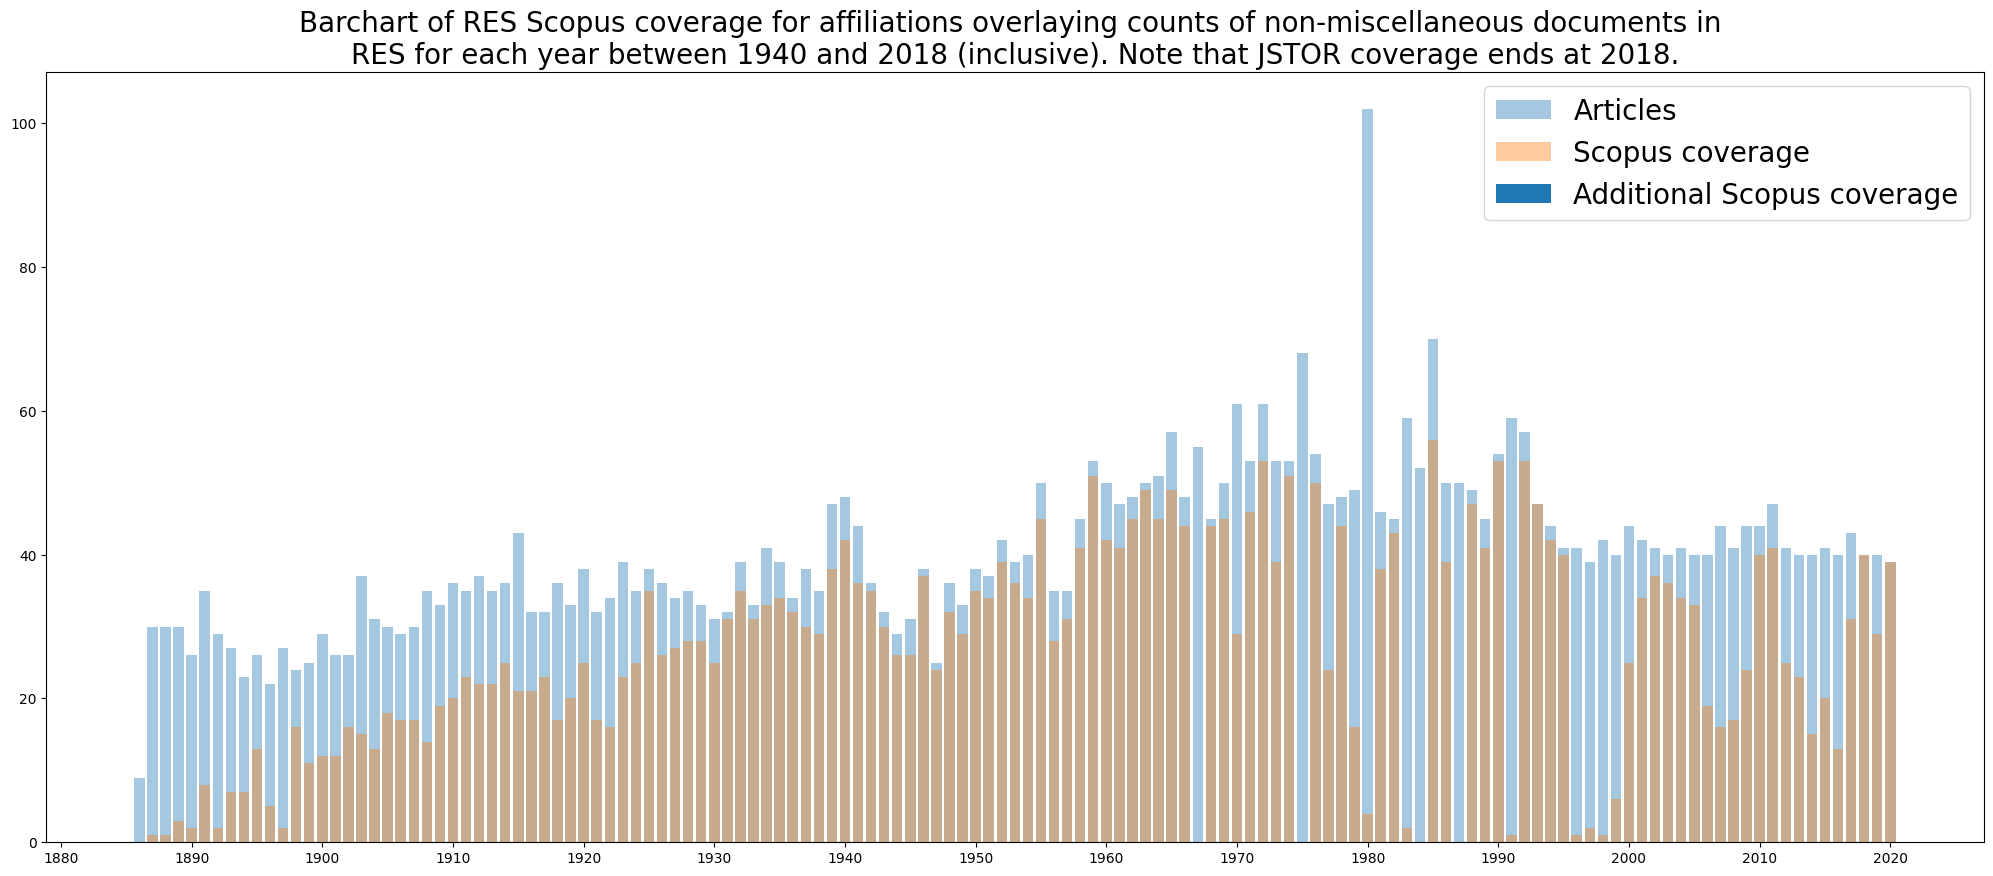

In [387]:
plt.rcParams["figure.figsize"] = (25, 10)
dta=Merged[(Merged['content_type']!='MISC')]['year'].value_counts()
plt.bar(dta.index,dta, label='Articles', alpha=0.4)
dta2=Merged[(Merged['affiliations'].isnull()==False) & (Merged['content_type']!='MISC')]['year'].value_counts()
dta3=scopus[(scopus['affiliations'].isnull()==False) & (scopus['year']>2020)]['year'].value_counts()
plt.bar(dta2.index, dta2, label='Scopus coverage', alpha=0.4)
plt.bar(dta3.index, dta3, label='Additional Scopus coverage', alpha=0.4)
plt.title('Barchart of RES Scopus coverage for affiliations overlaying counts of non-miscellaneous documents in \nRES for each year between 1940 and 2018 (inclusive). Note that JSTOR coverage ends at 2018.', fontsize=20)
plt.xticks(np.arange(1880, 2030, 10))
plt.legend(prop={'size': 20})

In [18]:
sc_aff=Merged[(Merged['affiliations'].isnull()==False) & (Merged['content_type']!='MISC')][['year','volume','issue']].value_counts()
js_aff=Merged[(Merged['content_type']!='MISC')][['year','volume','issue']].value_counts()

In [19]:
difference=pd.DataFrame(js_aff-sc_aff).reset_index()  #get difference
difference=pd.merge(difference, js_aff.reset_index(), on=['year', 'issue','volume'], how='right').sort_values(['year','issue','volume'])
difference['retrieval_req']=difference['0_x']/difference['0_y']
difference.rename(columns = {'0_x':'missing', '0_y':'total'}, inplace = True)
difference['retrieval_req'] = difference['retrieval_req'].fillna(1)

difference[difference['year']>=1940] # if missing is NaN that means the whole issue is missing.


,year,volume,issue,missing,total,retrieval_req
141,1940,55,1,1.0,11,0.090909
10,1940,54,2,3.0,16,0.187500
255,1940,54,3,1.0,10,0.100000
102,1940,54,4,2.0,12,0.166667
79,1941,56,1,3.0,13,0.230769
...,...,...,...,...,...,...
232,2015,130,4,6.0,10,0.600000
231,2016,131,1,NaN,10,1.000000
228,2016,131,2,3.0,10,0.300000
226,2016,131,3,4.0,10,0.400000


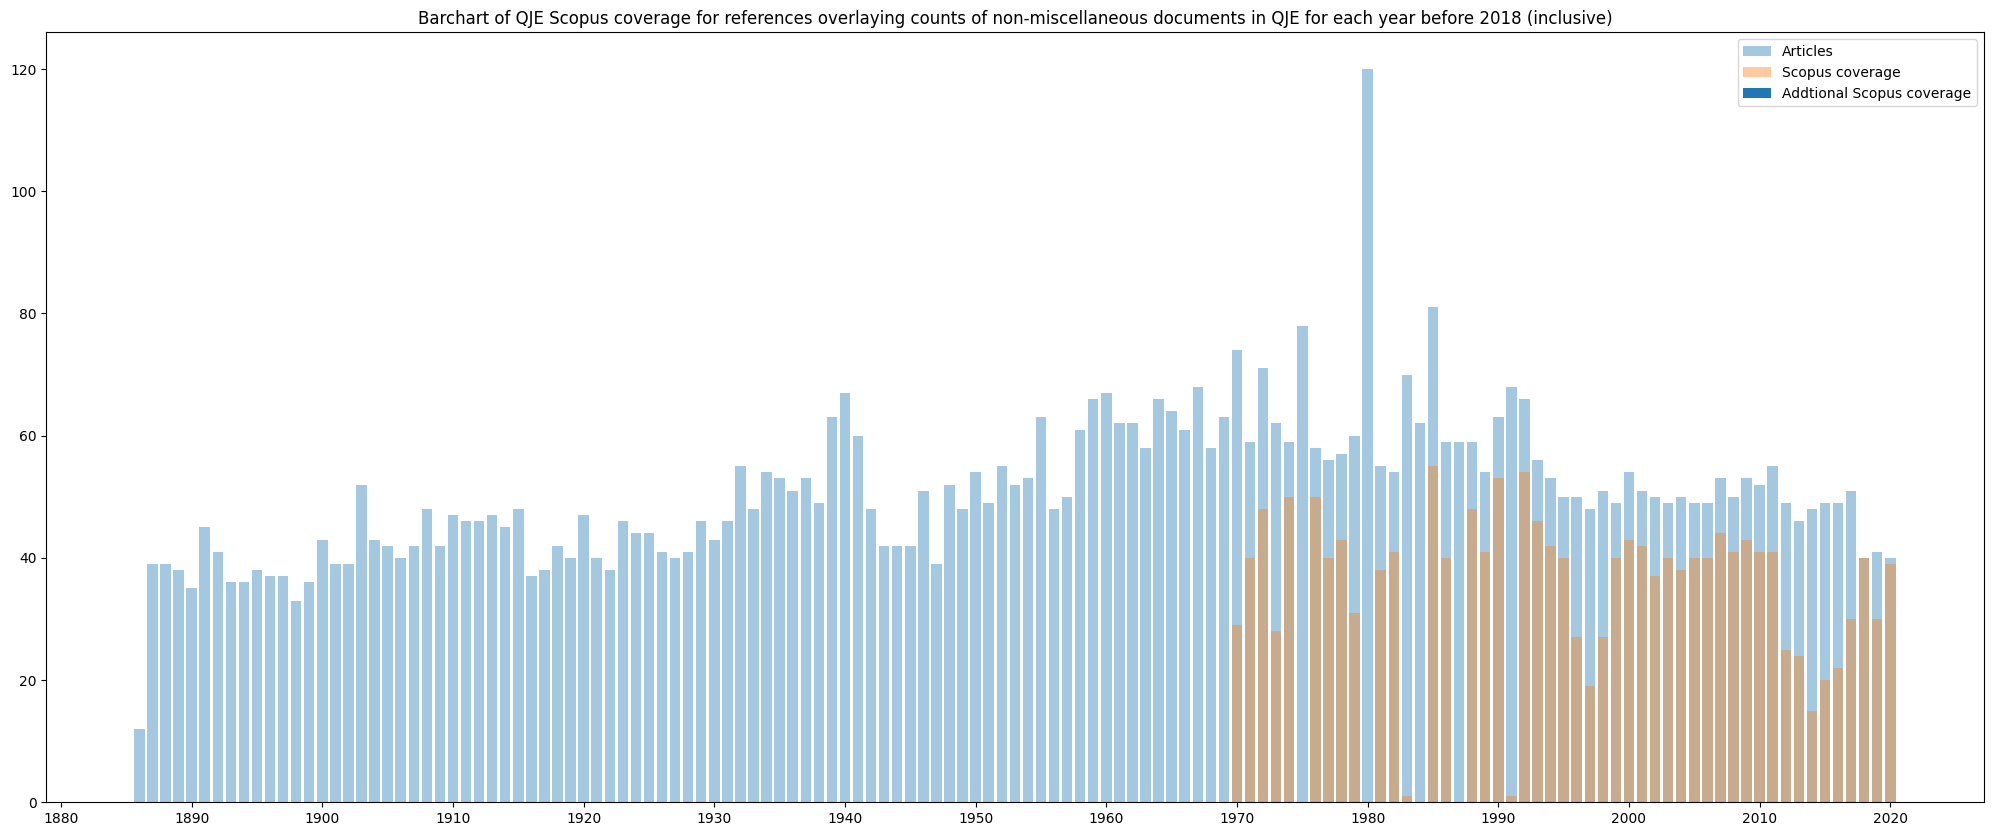

In [390]:
plt.rcParams["figure.figsize"] = (25, 10)
dta=Merged['year'].value_counts()
dta.index
plt.bar(dta.index, dta, alpha=0.4, label='Articles')

dta4=Merged[(Merged['citations'].isnull()==False) & (Merged['content_type']!='MISC')]['year'].value_counts()
plt.bar(dta4.index, dta4, alpha=0.4, label='Scopus coverage')
dta5=scopus[(scopus['citations'].isnull()==False) & (scopus['year']>2020)]['year'].value_counts()
plt.bar(dta5.index, dta5, alpha=0.4, label='Addtional Scopus coverage')
plt.title('Barchart of QJE Scopus coverage for references overlaying counts of non-miscellaneous documents in QJE for each year before 2018 (inclusive)')
plt.xticks(np.arange(1880, 2030, 10))
plt.legend()